In [169]:
#Import S&P500 Data
import yfinance as yf
import numpy as np
import pandas as pd
from pandas import DataFrame
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
del sp500["Dividends"]
del sp500["Stock Splits"]

In [170]:
#Clean data and create intended features
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Label"] = 2 * (sp500["Tomorrow"] > sp500["Close"]).astype(int) - 1

#Only uses more recent data
sp500 = sp500.loc["2010-01-01":].copy()

#Includes rolling averages for additional features
horizons = [3,10,25]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    #Ratio of closing date from yesterday over rolling average of the closing dates
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    #Sum of labels divided by number of days in rolling average
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = (sp500.shift(1).rolling(horizon).sum()["Label"])/horizon
    
    new_predictors += [ratio_column, trend_column]
    
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Label,Close_Ratio_3,Trend_3,Close_Ratio_10,Trend_10,Close_Ratio_25,Trend_25
Date,,,,,,,,,,,,,
2010-02-09 00:00:00-05:00,1060.060059,1079.280029,1060.060059,1070.520020,5114260000,1068.130005,-1,1.005671,0.333333,0.991016,0.0,0.964036,0.12
2010-02-10 00:00:00-05:00,1069.680054,1073.670044,1059.339966,1068.130005,4251450000,1078.469971,1,1.002817,-0.333333,0.991499,-0.2,0.964259,0.04
2010-02-11 00:00:00-05:00,1067.099976,1080.040039,1060.589966,1078.469971,4400870000,1075.510010,-1,1.005685,0.333333,1.001661,0.0,0.975661,0.04
2010-02-12 00:00:00-05:00,1075.949951,1077.810059,1062.969971,1075.510010,4160680000,1094.869995,1,1.001372,-0.333333,0.998759,0.0,0.975319,-0.04
2010-02-16 00:00:00-05:00,1079.130005,1095.670044,1079.130005,1094.869995,4080770000,1099.510010,1,1.011007,0.333333,1.016202,0.0,0.994683,-0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05 00:00:00-04:00,5158.950195,5222.180176,5157.209961,5204.339844,3386780000,5202.390137,-1,1.003211,0.333333,0.997546,-0.2,1.005288,-0.04
2024-04-08 00:00:00-04:00,5211.370117,5219.569824,5197.350098,5202.390137,3278180000,5209.910156,1,1.003422,-0.333333,0.997781,-0.2,1.004405,-0.12
2024-04-09 00:00:00-04:00,5217.029785,5224.810059,5160.779785,5209.910156,3400680000,5160.640137,-1,1.000838,0.333333,0.999382,0.0,1.005244,-0.04


In [171]:
#Makes the data into percentages so it can be encoded into the quantum circuit
sp500["Close"] = (sp500["Close"]-sp500["Open"])/sp500["Open"]
sp500["High"] = (sp500["High"]-sp500["Open"])/sp500["Open"]
sp500["Low"] = (sp500["Low"]-sp500["Open"])/sp500["Open"]
sp500["Volume"] = (sp500["Volume"] - sp500["Volume"].min())/sp500["Volume"].max()

#Drops data that we don't want to use in training
predictors = sp500.drop(["Open", "Tomorrow","Label"], axis=1)
predictors = DataFrame.to_numpy(predictors)
labels = (DataFrame.to_numpy(sp500))[:,6]
num_features = np.size(predictors, axis=1)

In [172]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

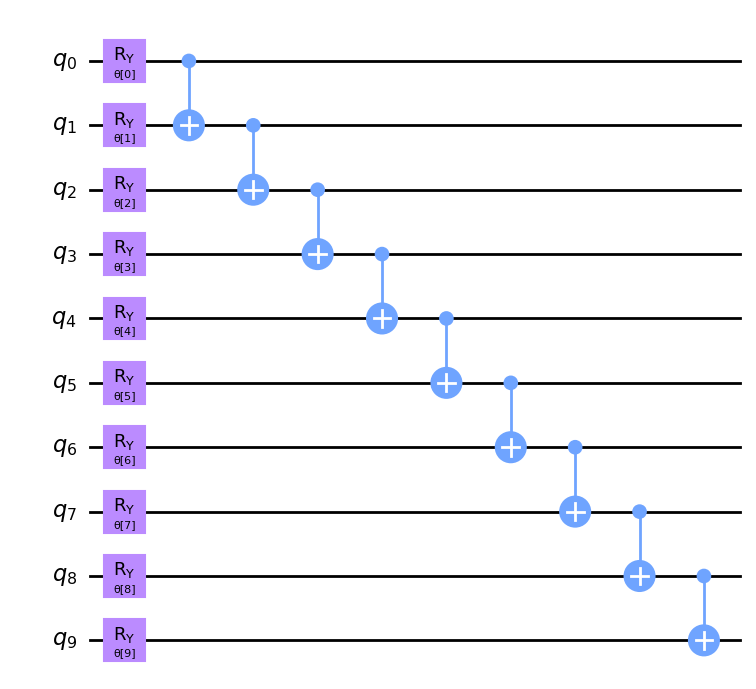

In [173]:
#Function to create the gates with parameters that we will modify through ML techniques
num_params = 10
def parametrized_gates(params):
    target = QuantumCircuit(num_features)
    
    for i in range(num_features):
        target.ry(params[i], i)
        
    for i in range(num_features-1):
        target.cx(i, i+1)
    
    return target

#Draws the ciruit for parametrized gate
params = ParameterVector("θ", length=num_params)
circuit = parametrized_gates(params)
circuit.draw("mpl", style="clifford")

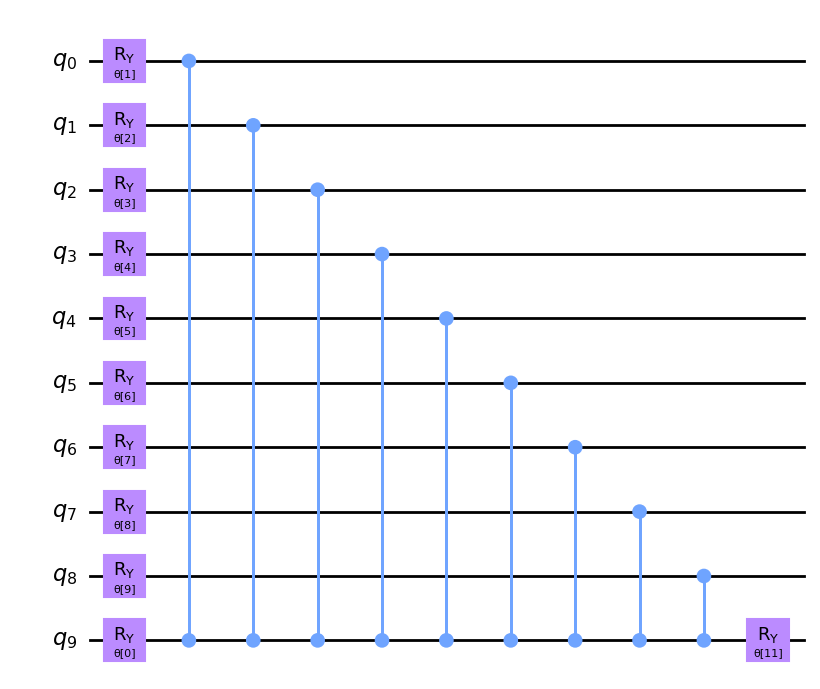

In [174]:
#Circuit to help with dimensionality reduction and combine two qubits into one
def pool_circuit(params):
    target = QuantumCircuit(num_features)
    
    target.ry(params[0], num_features-1)
    for i in range(num_features-1):
        target.ry(params[i+1], i)
        target.cz(i,9)
    
    target.ry(params[num_features+1], num_features-1)

    return target


params = ParameterVector("θ", length=num_features+2)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

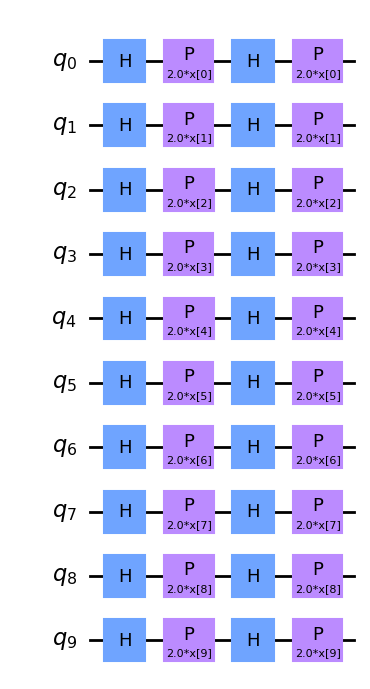

In [175]:
#Qiskits default circuit for encoding data
from qiskit.circuit.library import ZFeatureMap
feature_map = ZFeatureMap(np.size(predictors, axis=1))
feature_map.decompose().draw("mpl", style="clifford")

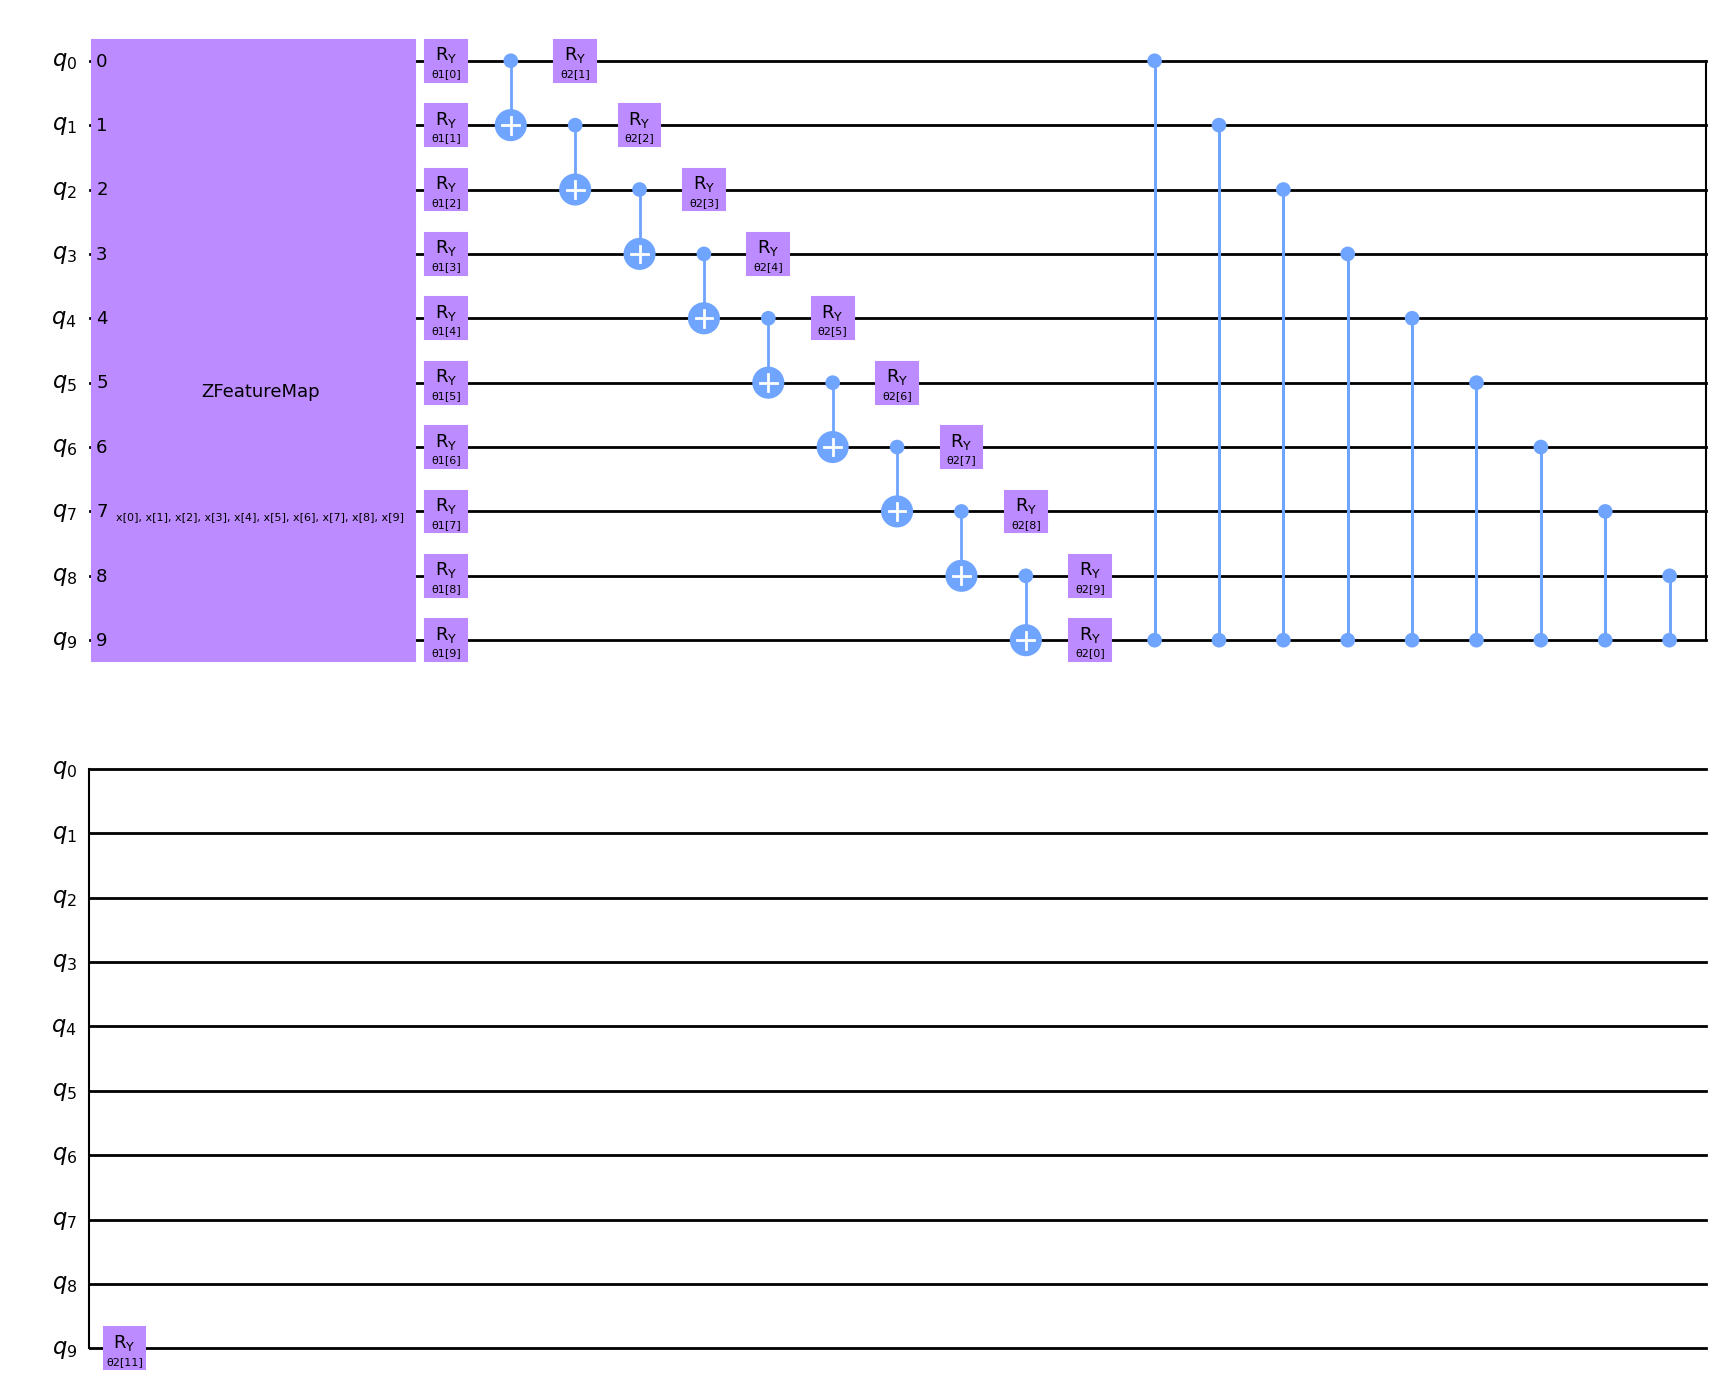

In [176]:
#Sets up full circuit with inputs and network
network = parametrized_gates(ParameterVector("θ1", length=num_params))
network.compose(pool_circuit(ParameterVector("θ2", length=num_features+2)), inplace=True)
ml_circuit = QuantumCircuit(num_features)
ml_circuit.compose(feature_map, inplace=True)
ml_circuit.compose(network, inplace=True)
ml_circuit.draw("mpl", style="clifford")

In [177]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from IPython.display import clear_output

In [178]:
#Sets up qiskit's neural network from the library
observable = SparsePauliOp.from_list([("Z" + "I" * 9, 1)])
qnn = EstimatorQNN(
    circuit=ml_circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=network.parameters,
)

In [179]:
#Function used in classifier to plot objective function at each iteration
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [180]:
#Sets up Classifier with COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph
)

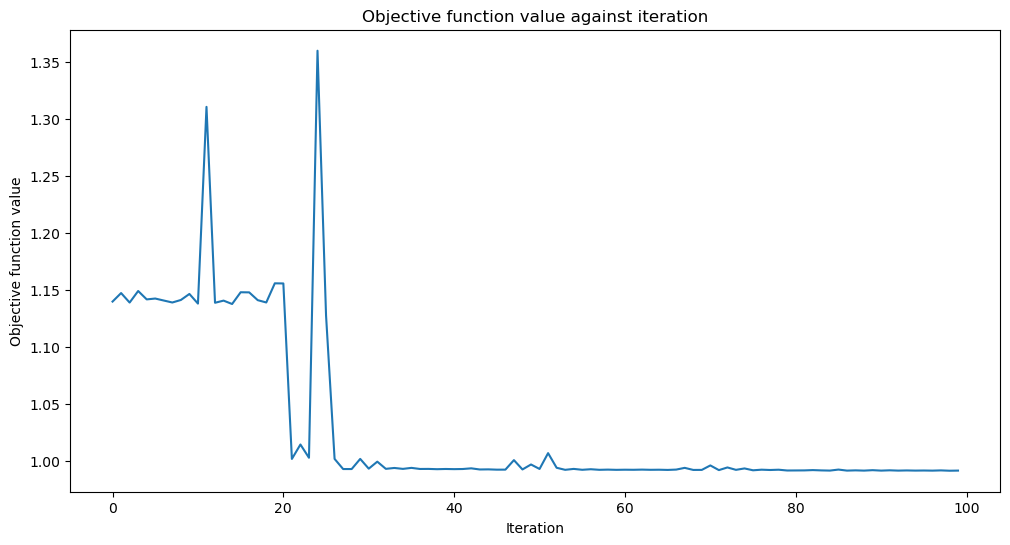

Accuracy from the test data : 54.28%


In [182]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#Trains the network and plots objective function vs iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(predictors, labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(predictors, labels), 2)}%")